In [1]:
#tf.keras.layers.Conv2D(filters, kernel_size, ...)
#e.g. in order to create 3D filters in the size of 3x3, these arguments are used:
#tf.keras.layers.Conv2D(3, (3,3), ...)

In [ ]:
#Let's start by importing required packages:
"""
os — to read files and directory structure
numpy — for some matrix math outside of TensorFlow
matplotlib.pyplot — to plot the graph and display images in our training and validation data
"""

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
#Data Loading
"""
To build our image classifier, we begin by downloading the dataset.
The dataset we are using is a filtered version of Dogs vs. Cats dataset from Kaggle (ultimately, this dataset is provided by Microsoft Research).

In previous Colabs, we've used TensorFlow Datasets, which is a very easy and convenient way to use datasets.
In this Colab however, we will make use of the class tf.keras.preprocessing.image.ImageDataGenerator which will read data from disk.
We therefore need to directly download Dogs vs. Cats from a URL and unzip it to the Colab filesystem.
"""

In [6]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 16s 0us/step


In [8]:
#The dataset we have downloaded has the following directory structure.
"""
cats_and_dogs_filtered
|__ train
    |______ cats: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ validation
    |______ cats: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
"""
#We can list the directories with the following terminal command:

'\ncats_and_dogs_filtered\n|__ train\n    |______ cats: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]\n    |______ dogs: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]\n|__ validation\n    |______ cats: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]\n    |______ dogs: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]\n'

In [10]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

FIND: Parameter format not correct


In [11]:
#We'll now assign variables with the proper file path for the training and validation sets.
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [12]:
#Understanding our data

#Let's look at how many cats and dogs images we have in our training and validation directory

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [13]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [15]:
#Setting Model Parameters

#For convenience, we'll set up variables that will be used later while pre-processing our dataset and training our network.
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

In [16]:
#Data Preparation

"""
Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network.
The steps involved in preparing these images are:

Read images from the disk
Decode contents of these images and convert it into proper grid format as per their RGB content
Convert them into floating point tensors
Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.
"""

#Fortunately, all these tasks can be done using the class tf.keras.preprocessing.image.ImageDataGenerator.
#We can set this up in a couple of lines of code.
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

In [17]:
#After defining our generators for training and validation images,
#flow_from_directory method will load images from the disk, apply rescaling, and resize them using single line of code.

train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [18]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


In [19]:
#Visualizing Training images

#We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using matplotlib.

sample_training_images, _ = next(train_data_gen) 

In [20]:
#The next function returns a batch from the dataset. One batch is a tuple of (many images, many labels).
#For right now, we're discarding the labels because we just want to look at the images.

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

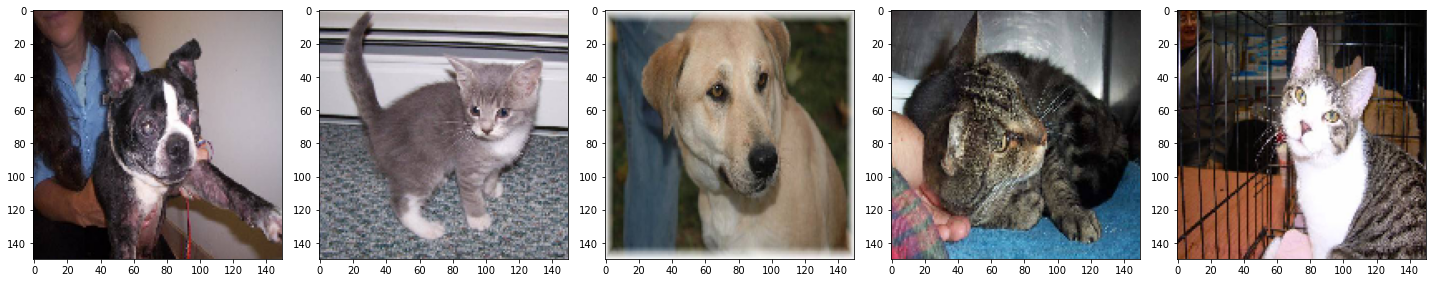

In [21]:
plotImages(sample_training_images[:5])  # Plot images 0-4

In [22]:
#Model Creation

In [23]:
#Define the model

"""
The model consists of four convolution blocks with a max pool layer in each of them.
Then we have a fully connected layer with 512 units, with a relu activation function.
The model will output class probabilities for two classes — dogs and cats — using softmax.
"""

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [24]:
#Compile the model

#As usual, we will use the adam optimizer.
#Since we output a softmax categorization, we'll use sparse_categorical_crossentropy as the loss function.
#We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
#Model Summary

#Let's look at all the layers of our network using summary method.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [26]:
#Train the model

#It's time we train our network.
#Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.

EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

C:\Users\fortn\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
20/20 [==============================] - 161s 8s/step - loss: 0.7340 - accuracy: 0.5215 - val_loss: 0.6912 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 111s 6s/step - loss: 0.6897 - accuracy: 0.5432 - val_loss: 0.6868 - val_accuracy: 0.5010
Epoch 3/100
20/20 [==============================] - 112s 6s/step - loss: 0.6834 - accuracy: 0.5467 - val_loss: 0.6671 - val_accuracy: 0.5440
Epoch 4/100
20/20 [==============================] - 104s 5s/step - loss: 0.6630 - accuracy: 0.5742 - val_loss: 0.6259 - val_accuracy: 0.6390
Epoch 5/100
20/20 [==============================] - 114s 6s/step - loss: 0.6093 - accuracy: 0.6635 - val_loss: 0.6265 - val_accuracy: 0.6440
Epoch 6/100
20/20 [==============================] - 110s 5s/step - loss: 0.5691 - accuracy: 0.7014 - val_loss: 0.5659 - val_accuracy: 0.7050
Epoch 7/100
20/20 [==============================] - 127s 6s/step - loss: 0.5487 - accuracy: 0.7097 - val_loss: 0.5836 - val_accuracy: 0.6920
Epoch 

Epoch 58/100
20/20 [==============================] - 108s 5s/step - loss: 8.7471e-05 - accuracy: 1.0000 - val_loss: 1.8662 - val_accuracy: 0.7500
Epoch 59/100
20/20 [==============================] - 110s 5s/step - loss: 7.3882e-05 - accuracy: 1.0000 - val_loss: 1.8747 - val_accuracy: 0.7510
Epoch 60/100
20/20 [==============================] - 105s 5s/step - loss: 7.8522e-05 - accuracy: 1.0000 - val_loss: 1.8811 - val_accuracy: 0.7500
Epoch 61/100
20/20 [==============================] - 107s 5s/step - loss: 6.6077e-05 - accuracy: 1.0000 - val_loss: 1.8901 - val_accuracy: 0.7510
Epoch 62/100
20/20 [==============================] - 117s 6s/step - loss: 7.0710e-05 - accuracy: 1.0000 - val_loss: 1.8956 - val_accuracy: 0.7510
Epoch 63/100
20/20 [==============================] - 107s 5s/step - loss: 6.3939e-05 - accuracy: 1.0000 - val_loss: 1.9067 - val_accuracy: 0.7510
Epoch 64/100
20/20 [==============================] - 113s 6s/step - loss: 6.6550e-05 - accuracy: 1.0000 - val_loss: 1

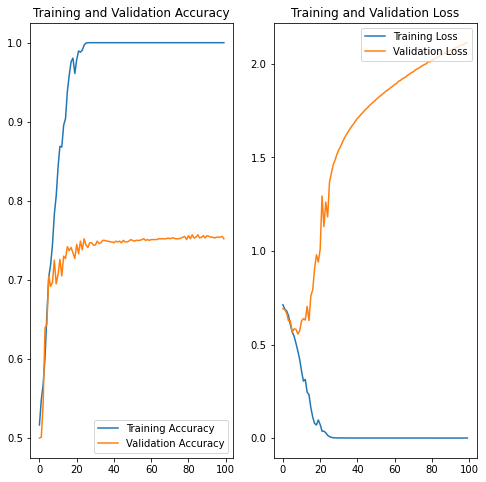

In [27]:
#Visualizing results of the training

#We'll now visualize the results we get after training our network.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

In [ ]:
"""
As we can see from the plots, training accuracy and validation accuracy are off by large margin and our model has achieved only around 70% accuracy on the validation set (depending on the number of epochs you trained for).

This is a clear indication of overfitting.
Once the training and validation curves start to diverge, our model has started to memorize the training data and is unable to perform well on the validation data.
"""

In [ ]:
#Softmax and Sigmoid

In [ ]:
"""
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
"""

In [ ]:
#Notice that our last layer (our classifier) consists of a Dense layer with 2 output units and a softmax activation function, as seen below:

 #    tf.keras.layers.Dense(2, activation='softmax')

In [ ]:
#Another popular approach when working with binary classification problems, is to use a classifier that consists of a Dense layer with 1 output unit and a sigmoid activation function, as seen below:

#     tf.keras.layers.Dense(1, activation='sigmoid')

In [ ]:
"""
Either of these two options will work well in a binary classification problem.
However, you should keep in mind, that if you decide to use a sigmoid activation function in your classifier,
you will also have to change the loss parameter in the model.compile() method,
from 'sparse_categorical_crossentropy' to 'binary_crossentropy', as shown below:
"""

"""
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
"""

In [1]:
###With Augmentation

#Setting till "Setting Model Parameters" will remain the same

In [2]:
#Specific concepts that will be covered:
"""
In the process, we will build practical experience and develop intuition around the following concepts

Building data input pipelines using the tf.keras.preprocessing.image.ImageDataGenerator class — How can we efficiently work with data on disk to interface with our model?
Overfitting - what is it, how to identify it, and how can we prevent it?
Data Augmentation and Dropout - Key techniques to fight overfitting in computer vision tasks that we will incorporate into our data pipeline and image classifier model.
We will follow the general machine learning workflow:
Examine and understand data
Build an input pipeline
Build our model
Train our model
Test our model
Improve our model/Repeat the process
"""

'\nIn the process, we will build practical experience and develop intuition around the following concepts\n\nBuilding data input pipelines using the tf.keras.preprocessing.image.ImageDataGenerator class — How can we efficiently work with data on disk to interface with our model?\nOverfitting - what is it, how to identify it, and how can we prevent it?\nData Augmentation and Dropout - Key techniques to fight overfitting in computer vision tasks that we will incorporate into our data pipeline and image classifier model.\nWe will follow the general machine learning workflow:\nExamine and understand data\nBuild an input pipeline\nBuild our model\nTrain our model\nTest our model\nImprove our model/Repeat the process\n'

In [3]:
#Data Augmentation
"""
Overfitting often occurs when we have a small number of training examples.
One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples.
Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images.

The goal is that at training time, your model will never see the exact same picture twice.
This exposes the model to more aspects of the data, allowing it to generalize better.

In tf.keras we can implement this using the same ImageDataGenerator class we used before.
We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

To start off, let's define a function that can display an image, so we can see the type of augmentation that has been performed.
Then, we'll look at specific augmentations that we'll use during training.
"""

"\nOverfitting often occurs when we have a small number of training examples.\nOne way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples.\nData augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images.\n\nThe goal is that at training time, your model will never see the exact same picture twice.\nThis exposes the model to more aspects of the data, allowing it to generalize better.\n\nIn tf.keras we can implement this using the same ImageDataGenerator class we used before.\nWe can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.\n\nTo start off, let's define a function that can display an image, so we can see the type of augmentation that has been performed.\nThen, we'll look

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
#Flipping the image horizontally

#We can begin by randomly applying horizontal flip augmentation to our dataset and seeing how individual images will look after the transformation.
#This is achieved by passing horizontal_flip=True as an argument to the ImageDataGenerator class.

image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

In [ ]:
#To see the transformation in action, let's take one sample image from our training set and repeat it five times.
#The augmentation will be randomly applied (or not) to each repetition.

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
#Rotating the image

#The rotation augmentation will randomly rotate the image up to a specified number of degrees. Here, we'll set it to 45.

image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

In [ ]:
#To see the transformation in action, let's once again take a sample image from our training set and repeat it.
#The augmentation will be randomly applied (or not) to each repetition.

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
#Applying Zoom

#We can also apply Zoom augmentation to our dataset, zooming images up to 50% randomly.

image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

In [ ]:
#One more time, take a sample image from our training set and repeat it.
#The augmentation will be randomly applied (or not) to each repetition.

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
#Putting it all together

#We can apply all these augmentations, and even others, with just one line of code, by passing the augmentations as arguments with proper values.

#Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.

image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

In [ ]:
#Let's visualize how a single image would look like five different times, when we pass these augmentations randomly to our dataset.

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
#Creating Validation Data generator

"""
Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage.
So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.
"""

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

In [ ]:
###Model Creation

#Define the model
"""
The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5.
It means that 50% of the values coming into the Dropout layer will be set to zero.
This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a relu activation function.
The model will output class probabilities for two classes — dogs and cats — using softmax.
"""

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [1]:
#Compiling the model
"""
As usual, we will use the adam optimizer.
Since we output a softmax categorization, we'll use sparse_categorical_crossentropy as the loss function.
We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.
"""
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

NameError: name 'model' is not defined

In [ ]:
###Model Summary
#Let's look at all the layers of our network using summary method.

model.summary()

In [ ]:
###Train the model
#It's time we train our network.
#Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.

epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

In [ ]:
###Visualizing results of the training
#We'll now visualize the results we get after training our network.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
###Other Techniques to Prevent Overfitting

"""
Three different techniques to prevent overfitting:
1. Early Stopping: In this method, we track the loss on the validation set during the training phase and use it to determine when to stop training such that the model is accurate but not overfitting.
2. Image Augmentation: Artificially boosting the number of images in our training set by applying random image transformations to the existing images in the training set.
3. Dropout: Removing a random selection of a fixed number of neurons in a neural network during training.
"""
"""
More techniques available to prevent overfitting:
https://hackernoon.com/memorizing-is-not-learning-6-tricks-to-prevent-overfitting-in-machine-learning-820b091dc42
"""